In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import math

2024-10-20 03:40:06.891096: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-20 03:40:06.950481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-20 03:40:06.951156: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 03:40:08.519100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def custom_activation(x):
    return 1+tf.math.cos(x) # play with imaginary

NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    # tf.keras.layers.Dense(units = 50, activation = "tanh"),
    # tf.keras.layers.Dense(units = 50, activation = "relu"),
    tf.keras.layers.Dense(units = 20, activation = custom_activation),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 61 (244.00 Byte)
Trainable params: 61 (244.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-10-20 03:40:10.390263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-20 03:40:10.392850: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.01)
w=2
def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)

    with tf.GradientTape(persistent=True) as g:
        g.watch(t)
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(t)
            u = net(t)
        u_t = gg.gradient(u, t)
    u_tt = g.gradient(u_t, t)

    # print(u_tt)
    ode_loss = u_tt + (w**2)*u
    IC_loss1 = u[0] - 1
    IC_loss2 = u_t[0] - 0  # u_tt(at t=0) = 0
    
    
    square_loss = tf.square(ode_loss) + tf.square(IC_loss1) + tf.square(IC_loss2)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss


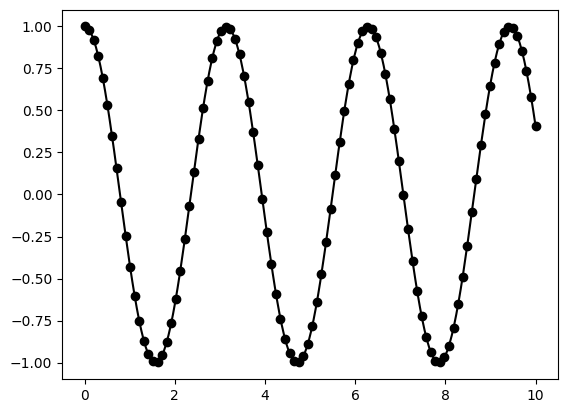

In [4]:
# def chebyshev_nodes(a, b, n):
#     # n Chebyshev noder i intervallet [a, b]
#     i = np.array(range(n))
#     x = np.cos((2*i+1)*math.pi/(2*(n))) # noder over [-1,1]
#     return np.sort(0.5*(b-a)*x+0.5*(b+a)) # noder over interval [a,b]

test_t = np.linspace(0, 10, 200)
true_u = np.cos(w*test_t)
plt.plot(test_t, true_u, '-k',label = 'Analytical')

# train_t = (np.array([0., np.pi, 2*np.pi, 3*np.pi])).reshape(-1, 1)
train_t = np.linspace(0, 10, 100).reshape(-1, 1) #chebyshev
# train_t = chebyshev_nodes(0, 10, 50)
train_u = np.cos(w*train_t)
plt.plot(train_t, train_u,'ok', label = 'Train')
# print(train_t)

4/4 [==============================] - 0s 1ms/step
itr:  0 loss:  26.882011
4/4 [==============================] - 0s 1ms/step
itr:  100 loss:  0.61807853
4/4 [==============================] - 0s 1ms/step
itr:  200 loss:  0.60959566
4/4 [==============================] - 0s 1ms/step
itr:  300 loss:  0.60705596
4/4 [==============================] - 0s 1ms/step
itr:  400 loss:  0.6039357
4/4 [==============================] - 0s 1ms/step
itr:  500 loss:  0.59866613
4/4 [==============================] - 0s 2ms/step
itr:  600 loss:  0.59126973
4/4 [==============================] - 0s 1ms/step
itr:  700 loss:  0.5861366
4/4 [==============================] - 0s 1ms/step
itr:  800 loss:  0.5818994
4/4 [==============================] - 0s 1ms/step
itr:  900 loss:  0.57567614
4/4 [==============================] - 0s 1ms/step
itr:  1000 loss:  0.5645077
4/4 [==============================] - 0s 1ms/step
itr:  1100 loss:  0.5342299
4/4 [==============================] - 0s 1ms/step
itr:  1

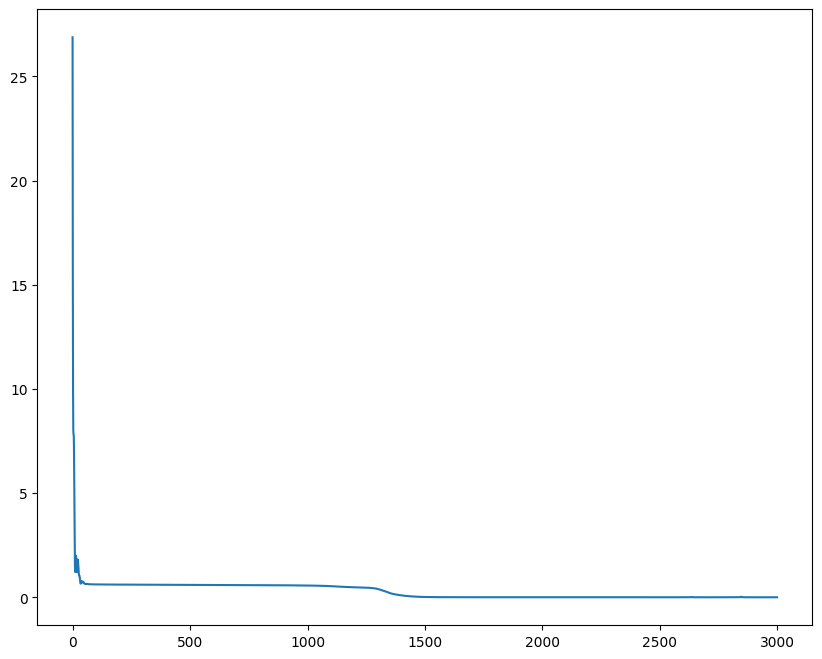

In [5]:
train_loss_record = []
predictions_record = []
iter = 3000
for itr in range(iter):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)

    grad_w = tape.gradient(train_loss, NN.trainable_variables)
    optm.apply_gradients(zip(grad_w, NN.trainable_variables))
        
    if itr % 100 == 0:
        pred_u = NN.predict(train_t).ravel()
        predictions_record.append(pred_u)
        print("itr: ", itr, "loss: ", train_loss.numpy())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

In [6]:
len(predictions_record[0])


100

In [7]:
test_t = np.linspace(0, 10, 100)

train_u = np.cos(w*train_t)
true_u = np.cos(w*test_t)
pred_u = NN.predict(test_t).ravel()

plt.figure()
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k',label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.show()

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/MatMul' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/trish/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/trish/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/home/trish/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/trish/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/trish/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/trish/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/trish/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/trish/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/trish/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/trish/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/home/trish/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/home/trish/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/trish/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/trish/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/trish/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_40937/2287033211.py", line 5, in <module>
      pred_u = NN.predict(test_t).ravel()
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/trish/.local/lib/python3.8/site-packages/keras/src/layers/core/dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential/dense/MatMul'
In[0] ndims must be >= 2: 1
	 [[{{node sequential/dense/MatMul}}]] [Op:__inference_predict_function_900462]

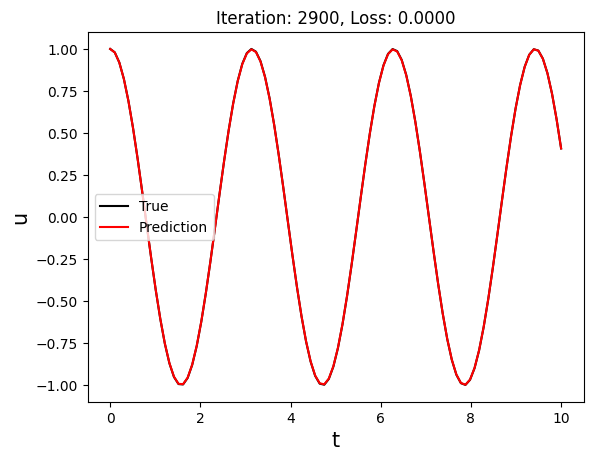

In [8]:
# animate
from matplotlib.animation import FuncAnimation
# Define the figure and axis for plotting
fig, ax = plt.subplots()
ax.plot(test_t, true_u, '-k',label = 'True')
line, = ax.plot(train_t, predictions_record[len(predictions_record)-1], '-r', label='Prediction')
ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('u', fontsize=15)
ax.set_title('Training Progress')
ax.legend(fontsize=10)


# Function to update the plot for each frame
def update_plot(frame):
    pred_u = predictions_record[frame // 100]
    line.set_ydata(pred_u)
    ax.set_title(f'Iteration: {frame}, Loss: {train_loss_record[frame]:.4f}')
    return line,

# Create the animation
ani = FuncAnimation(fig, update_plot, frames=range(0, iter, 100), blit=True)

# Save the animation as a gif
ani.save('training_progress.gif', writer='pillow')

plt.show()